In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import numpy as np
import torch

# dust3r_path = str(Path(os.path.join(os.getcwd())).parent / "dust3r" / "dust3r")
# sys.path.append(dust3r_path)
sys.path.append("../dust3r")

In [4]:
from dust3r.cloud_opt import GlobalAlignerMode, global_aligner
from dust3r.image_pairs import make_pairs
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/Users/kevinlu/miniconda3/envs/annotated-dust3r/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = "cpu"
batch_size = 1
schedule = "cosine"
lr = 0.01
niter = 300

model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

In [6]:
import sys

import numpy as np
import torch

sys.path.append(".")

from load_images import LoadConfig, load_images

In [7]:
images_data = load_images(["assets/Chateau1.png", "assets/Chateau2.png"], config=LoadConfig(size=512))

INFO:load_images:>> Loading 2 images.
INFO:load_images: - Added assets/Chateau1.png with resolution 512x384
INFO:load_images: - Added assets/Chateau2.png with resolution 512x384
INFO:load_images: (Successfully loaded 2 images)


In [8]:
assert list(images_data[0].__dataclass_fields__.keys()) == [
    "img_tensor",
    "true_shape",
    "idx",
    "instance",
], images_data[0].__dataclass_fields__.keys()
assert images_data[0].img_tensor.shape == torch.Size([1, 3, 384, 512])
assert np.all(images_data[0].true_shape == np.array([[384, 512]]))
assert images_data[0].idx == 0
assert images_data[0].instance == "0"

assert list(images_data[1].__dataclass_fields__.keys()) == [
    "img_tensor",
    "true_shape",
    "idx",
    "instance",
], images_data[1].__dataclass_fields__.keys()
assert images_data[1].img_tensor.shape == torch.Size([1, 3, 384, 512])
assert np.all(images_data[1].true_shape == np.array([[384, 512]]))
assert images_data[1].idx == 1
assert images_data[1].instance == "1"

In [9]:
from make_pairs import make_pairs

In [10]:
pairs = make_pairs(images_data)

In [11]:
assert len(pairs) == 2
assert pairs[0] == (images_data[1], images_data[0])
assert pairs[1] == (images_data[0], images_data[1])

### Inference

In [20]:
from inference import collate_with_cat, inference, loss_of_one_batch

In [21]:
batch_size = 8
dict_pairs = [(p[0].to_dict(), p[1].to_dict()) for p in pairs]
assert len(dict_pairs) == 2
assert len(dict_pairs[0]) == 2
assert list(dict_pairs[0][0].keys()) == ["img", "true_shape", "idx", "instance"]

In [22]:
collated_dict_pairs = collate_with_cat(dict_pairs[0:batch_size])
assert len(collated_dict_pairs) == 2
assert len(collated_dict_pairs[0]) == 4
assert len(collated_dict_pairs[1]) == 4

In [23]:
output = loss_of_one_batch(collated_dict_pairs, model, criterion=None, device=device)

In [24]:
assert list(output["view1"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view1"]["img"].shape == torch.Size([2, 3, 384, 512])
assert output["view1"]["true_shape"].shape == torch.Size([2, 2])
assert np.all(output["view1"]["idx"] == np.array([1, 0]))
assert output["view1"]["instance"] == ["1", "0"]

In [25]:
assert list(output["view2"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view2"]["img"].shape == torch.Size([2, 3, 384, 512])
assert output["view2"]["true_shape"].shape == torch.Size([2, 2])
assert np.all(output["view2"]["idx"] == np.array([0, 1]))
assert output["view2"]["instance"] == ["0", "1"]

In [26]:
output = inference(pairs, model, device, batch_size=batch_size)

>> Inference with model on 2 image pairs


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.82s/it]


In [27]:
assert list(output.keys()) == ["view1", "view2", "pred1", "pred2", "loss"]

In [28]:
assert list(output["view1"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view1"]["img"].shape == torch.Size([2, 3, 384, 512])
assert output["view1"]["true_shape"].shape == torch.Size([2, 2])
assert np.all(output["view1"]["idx"] == np.array([1, 0]))
assert output["view1"]["instance"] == ["1", "0"]

In [29]:
assert list(output["view2"].keys()) == ["img", "true_shape", "idx", "instance"]
assert output["view2"]["img"].shape == torch.Size([2, 3, 384, 512])
assert output["view2"]["true_shape"].shape == torch.Size([2, 2])
assert np.all(output["view2"]["idx"] == np.array([0, 1]))
assert output["view2"]["instance"] == ["0", "1"]

In [30]:
image_0_idx = images_data[0].idx
image_1_idx = images_data[1].idx
image_0_idx_for_view_1_output = output["view1"]["idx"].index(image_0_idx)
image_1_idx_for_view_1_output = output["view1"]["idx"].index(image_1_idx)
image_0_idx_for_view_2_output = output["view2"]["idx"].index(image_0_idx)
image_1_idx_for_view_2_output = output["view2"]["idx"].index(image_1_idx)
image_0_for_view_1_output = output["view1"]["img"][image_0_idx_for_view_1_output]
image_0_for_view_2_output = output["view2"]["img"][image_0_idx_for_view_2_output]
image_1_for_view_1_output = output["view1"]["img"][image_1_idx_for_view_1_output]
image_1_for_view_2_output = output["view2"]["img"][image_1_idx_for_view_2_output]

assert torch.all(image_0_for_view_1_output == image_0_for_view_2_output)
assert torch.all(image_1_for_view_1_output == image_1_for_view_2_output)

In [31]:
assert list(output["pred1"].keys()) == ["pts3d", "conf"]
assert output["pred1"]["pts3d"].shape == torch.Size([2, 384, 512, 3])
assert output["pred1"]["conf"].shape == torch.Size([2, 384, 512])

In [32]:
assert list(output["pred2"].keys()) == ["conf", "pts3d_in_other_view"]
assert output["pred2"]["pts3d_in_other_view"].shape == torch.Size([2, 384, 512, 3])
assert output["pred2"]["conf"].shape == torch.Size([2, 384, 512])

In [33]:
assert output["loss"] == None

In [20]:
# at this stage, you have the raw dust3r predictions
view1, pred1 = output["view1"], output["pred1"]
view2, pred2 = output["view2"], output["pred2"]
# here, view1, pred1, view2, pred2 are dicts of lists of len(2)
#  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
# in each view you have:
# an integer image identifier: view1['idx'] and view2['idx']
# the img: view1['img'] and view2['img']
# the image shape: view1['true_shape'] and view2['true_shape']
# an instance string output by the dataloader: view1['instance'] and view2['instance']
# pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
# pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
# pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

# next we'll use the global_aligner to align the predictions
# depending on your task, you may be fine with the raw output and not need it
# with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
# if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

 init edge (1*,0*) score=48.34430694580078
 init loss = 0.006030205637216568
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|█████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.31it/s, lr=1.27413e-06 loss=0.0027559]


In [21]:
assert len(scene.imgs) == 2
assert scene.imgs[0].shape == (384, 512, 3)
assert len(scene.get_pts3d()) == 2
assert scene.get_pts3d()[0].shape == torch.Size([384, 512, 3])
assert len(scene.get_masks()) == 2
assert scene.get_masks()[0].shape == torch.Size([384, 512])

In [22]:
# retrieve useful values from scene:
imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

In [26]:
# visualize reconstruction
scene.show(viewer="gl")

In [47]:
# find 2D-2D matches between the two images
from dust3r.utils.geometry import find_reciprocal_matches, xy_grid

pts2d_list, pts3d_list = [], []
for i in range(2):
    conf_i = confidence_masks[i].cpu().numpy()
    pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])  # imgs[i].shape[:2] = (H, W)
    pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])

In [56]:
assert imgs[0].shape[:2][::-1] == (512, 384)

assert confidence_masks[0].cpu().numpy().shape == (384, 512)
assert xy_grid(*imgs[0].shape[:2][::-1]).shape == (384, 512, 2)
assert pts3d[0].detach().cpu().numpy().shape == (384, 512, 3)

# number of points selected for 2d should be the same as the mask where pixels are True
assert np.sum(confidence_masks[0].cpu().numpy()) == len(pts2d_list[0])
assert np.sum(confidence_masks[0].cpu().numpy()) == len(pts3d_list[0])

assert imgs[1].shape[:2][::-1] == (512, 384)

assert confidence_masks[1].cpu().numpy().shape == (384, 512)
assert xy_grid(*imgs[1].shape[:2][::-1]).shape == (384, 512, 2)
assert pts3d[1].detach().cpu().numpy().shape == (384, 512, 3)

# number of points selected for 2d should be the same as the mask where pixels are True
assert np.sum(confidence_masks[1].cpu().numpy()) == len(pts2d_list[1])
assert np.sum(confidence_masks[1].cpu().numpy()) == len(pts3d_list[1])

In [55]:
reciprocal_in_P2, nn2_in_P1, num_matches = find_reciprocal_matches(*pts3d_list)
print(f"found {num_matches} matches")
matches_im1 = pts2d_list[1][reciprocal_in_P2]
matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

found 32921 matches


Matplotlib is building the font cache; this may take a moment.


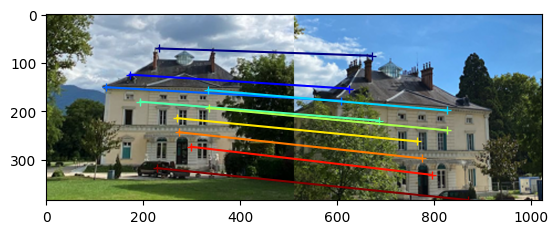

In [74]:
# visualize a few matches
import numpy as np
from matplotlib import pyplot as pl

n_viz = 10
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = (
    matches_im0[match_idx_to_viz],
    matches_im1[match_idx_to_viz],
)

H0, W0, H1, W1 = *imgs[0].shape[:2], *imgs[1].shape[:2]
img0 = np.pad(imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), "constant", constant_values=0)
img1 = np.pad(imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), "constant", constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap("jet")
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot(
        [x0, x1 + W0],
        [y0, y1],
        "-+",
        color=cmap(i / (n_viz - 1)),
        scalex=False,
        scaley=False,
    )
pl.show(block=True)